<a href="https://colab.research.google.com/github/meiqingli/dssj_summer2022/blob/main/DSSJ_Final_Project_Li.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Geographic Disparity in Publishing: A Sentiment Analysis from Subreddit Community**
**Meiqing Li | PhD Candidate in City and Regional Planning**

**DSSJ @ Berkeley**

In [ ]:
# import packages
import pandas as pd
import spacy
from gensim.models.phrases import Phrases, Phraser

# load the English preprocessing pipeline
nlp = spacy.load("en_core_web_sm")

## Introduction
The subreddit of interest is [Publishing](https://www.reddit.com/r/publishing/), which is a community for publishing professionals to discuss various issues such as career and business opportunities. Through initial qualitative analysis, we found it a relatively small community compared with other subreddits by number of readers and posts. In terms of topics, we found discussions on different types of publishing, for example self-publishing,publishing through agent, and digital publishing, as well as publishing in the US vs. Canada. These are all potential areas for further investigation. 

Before cleaning up, our dataset includes 7,330 posts and 19,538 comments. By removing blank texts, we reduced the size of dataset to 2,388 posts and 19,054 comments. There have been a total of 1,922 unique users for posts, and 4,033 unique users for comments. Interestingly, we noticed that the most frequent user's posts take up 1% of the overall posts while the next only takes up 0.3%. Another observation we find interesting is that people are curious about the differences in publishing between US and Canada, whilst it seems that most of the posts are from people trying to navigate publishing but very little from the publisher side. For this project, I would like to look into the posts by different people involved in publishing, specifically the themes and sentiments within posts from different areas or regions. For example, how do the sentiments and concerns regarding publishing differ between US, Canada and other countries, or different parts of the US? Also, within each geographic region, what are the shares of posts by people interested in publishing, publishers, agents, and other stakeholders? I am interested in studying these dynamics because they can give us a better understanding about the broader landscape of publishing. 

In order to address these questions, I will look into several NLP techniques inlcuding *topic modeling* and *sentiment analysis*. Specifically, I will use tools such as *concordance* to identify texts with geographical key words, then extract topical words and sentiments. 

In [ ]:
# Github url with post data
url_posts = 'https://gist.githubusercontent.com/meiqingli/2d128e1cac170d71b3820c51c6c3766e/raw/5be159378011713f1daaca4d683bb6875d11f61f/submissions.csv'

# Github url with comments data
url_comments = 'https://gist.githubusercontent.com/meiqingli/5d83de4c508a0564359b2dd07c6839b1/raw/a83a44b0a85ac8ccc10f717495ff6a85c2f93878/comments.csv'

# Reads the csv posts file from github
df_posts = pd.read_csv(url_posts)

# Reads the csv comments file from github
df_comments = pd.read_csv(url_comments)

In [ ]:
# Tells us about the general shape of the dfs
df_posts.shape

(7330, 18)

In [ ]:
df_comments.shape

(19538, 11)

In [ ]:
# Allows us to see which columns our dfs have
list(df_posts)

['idint',
 'idstr',
 'created',
 'self',
 'nsfw',
 'author',
 'title',
 'url',
 'selftext',
 'score',
 'subreddit',
 'distinguish',
 'textlen',
 'num_comments',
 'flair_text',
 'flair_css_class',
 'augmented_at',
 'augmented_count']

In [ ]:
list(df_comments)

['idint',
 'idstr',
 'created',
 'author',
 'parent',
 'submission',
 'body',
 'score',
 'subreddit',
 'distinguish',
 'textlen']

## Preprocessing
We mainly made the following preprocessing steps to the original dataset:

*   Drop redundant columns;
*   Remove rows in posts and comments that are either "removed" or "deleted";
*   Drop rows with null values in `selftext` and `body` columns;
*   Drop duplicate posts and columns;
*   Text cleaning using `spaCy`;
*   Phrase modeling with `gensim`;
*   Save preprocessed texts to new data frames for further analysis.

Code from this section is largely based on joint work by Madeline Bossi, Soliver Fusi, Janiya Peters, and me. 

In [ ]:
# Drops less useful columns

df_posts_short = df_posts.drop(['subreddit', 'url', 'distinguish', 'flair_text', 'flair_css_class', 'augmented_at', 'augmented_count'], axis=1)
df_comments_short = df_comments.drop(['subreddit', 'distinguish'], axis=1)

In [ ]:
# Selects all rows that don't have 'removed' or 'deleted' in certain columns
df_comments_noBlanks = df_comments_short.loc[~df_comments_short['body'].isin(['[removed]', '[deleted]' ]),:]
df_posts_noBlanks = df_posts_short.loc[~df_posts_short['selftext'].isin(['[removed]', '[deleted]' ]),:]

In [ ]:
# Drops rows with null values in 'selftext' or 'body' column (assuming we want to analyze 'selftext')
df_posts_noBlanks = df_posts_noBlanks.dropna(subset=['selftext'])
df_comments_noBlanks = df_comments_noBlanks.dropna(subset=['body'])

In [ ]:
# drop duplicate posts or comments
df_posts_noBlanks = df_posts_noBlanks.drop_duplicates(subset=['selftext'])
df_comments_noBlanks = df_comments_noBlanks.drop_duplicates(subset=['body'])

In [ ]:
# Final number of posts
df_posts_noBlanks.shape

(2385, 11)

In [ ]:
# Final number of comments
df_comments_noBlanks.shape

(18754, 9)

Our original dataset has 7,330 rows of posts and 19,538 rows of comments. After preprocessing, the dataset contains 2,385 posts and 18,754 comments, which are small subsets of the original ones. 

In [ ]:
def clean(token):
    """Helper function that specifies whether a token is:
        - punctuation
        - space
        - digit
    """
    return token.is_punct or token.is_space or token.is_digit

def line_read(df, text_col='selftext'):
    """Generator function to read in text from df and get rid of line breaks."""    
    for text in df[text_col]:
        yield text.replace('\n', '')

def preprocess_posts(df, text_col='selftext', allowed_postags=['NOUN', 'ADJ']):
    """Preprocessing function to apply to the posts dataframe."""
    for parsed in nlp.pipe(line_read(df, text_col), batch_size=1000, disable=["ner"]):
        # Gather lowercased, lemmatized tokens
        tokens = [token.lemma_.lower() if token.lemma_ != '-PRON-'
                  else token.lower_ 
                  for token in parsed if not clean(token)]
        # Remove specific lemmatizations, and words that are not nouns or adjectives
        tokens = [lemma
                  for lemma in tokens
                  if not lemma in ["'s",  "’s", "’"] and not lemma in allowed_postags]
        # Remove stop words
        tokens = [token for token in tokens if token not in spacy.lang.en.stop_words.STOP_WORDS]
        yield tokens

# created a different preprocessing function for the comments df because the relevant column name is different
def preprocess_comments(df, text_col='body', allowed_postags=['NOUN', 'ADJ']):
    """Preprocessing function to apply to the comments dataframe."""
    for parsed in nlp.pipe(line_read(df, text_col), batch_size=1000, disable=["ner"]):
        # Gather lowercased, lemmatized tokens
        tokens = [token.lemma_.lower() if token.lemma_ != '-PRON-'
                  else token.lower_ 
                  for token in parsed if not clean(token)]
        # Remove specific lemmatizations, and words that are not nouns or adjectives
        tokens = [lemma
                  for lemma in tokens
                  if not lemma in ["'s",  "’s", "’"] and not lemma in allowed_postags]
        # Remove stop words
        tokens = [token for token in tokens if token not in spacy.lang.en.stop_words.STOP_WORDS]
        yield tokens


In [ ]:
# creates a list of lists of lemmas in each post
lemmas_posts = [line for line in preprocess_posts(df_posts_noBlanks)]

# creates a list of lists of lemmas in each comment
lemmas_comments = [line for line in preprocess_comments(df_comments_noBlanks)]

In [ ]:
# flattens the list of lists into one big list to facilitate counting lemma frequency
flat_lemmas_posts = [item for sublist in lemmas_posts for item in sublist]
# flat_lemmas_posts[:30]

In [ ]:
# creates a df to see which lemmas are the most frequent
from collections import Counter
posts_count = Counter(flat_lemmas_posts)

lemma_freq_df_posts = pd.DataFrame.from_dict(posts_count, orient='index').reset_index()
lemma_freq_df_posts = lemma_freq_df_posts.rename(columns={'index':'lemma', 0:'count'})
lemma_freq_df_posts.sort_values('count', ascending=False)[:30]

,lemma,count
201,book,3134
187,publish,1794
2,publishing,1448
17,work,1393
3,like,1283
120,know,1130
188,want,1060
290,publisher,1059
174,write,971
77,look,836


In [ ]:
# replicates this same process for the comments
flat_lemmas_comments = [item for sublist in lemmas_comments for item in sublist]
# flat_lemmas_comments[:30]

In [ ]:
comments_count = Counter(flat_lemmas_comments)

lemma_freq_df_comments = pd.DataFrame.from_dict(comments_count, orient='index').reset_index()
lemma_freq_df_comments = lemma_freq_df_comments.rename(columns={'index':'lemma', 0:'count'})
lemma_freq_df_comments.sort_values('count', ascending=False)[:30]

,lemma,count
4,book,10150
72,work,5754
322,publisher,5155
6,publish,4775
25,publishing,4580
17,good,4248
161,like,4033
324,want,3643
170,author,3405
940,agent,3217


In [ ]:
# Forming bigrams and trigrams

# Create bigram and trigram models for posts
bigram_posts = Phrases(lemmas_posts, min_count=10, threshold=100)
trigram_posts = Phrases(bigram_posts[lemmas_posts], min_count=10, threshold=50)  
bigram_phraser_posts = Phraser(bigram_posts)
trigram_phraser_posts = Phraser(trigram_posts)

# Form trigrams
trigrams_posts = [trigram_phraser_posts[bigram_phraser_posts[doc]] for doc in lemmas_posts]

# Create bigram and trigram models for comments
bigram_comments = Phrases(lemmas_comments, min_count=10, threshold=100)
trigram_comments = Phrases(bigram_comments[lemmas_comments], min_count=10, threshold=50)  
bigram_phraser_comments = Phraser(bigram_comments)
trigram_phraser_comments = Phraser(trigram_comments)

# Form trigrams
trigrams_comments = [trigram_phraser_comments[bigram_phraser_comments[doc]] for doc in lemmas_comments]

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# joins each into a string
trigrams_joined_posts = [' '.join(trigram) for trigram in trigrams_posts]
trigrams_joined_posts[0]

'industry experience publishing like enter field specifically editing usual catch-22 hold true job need experience experience need job find entry_level work prove difficult live baltimore md feel exhaust obvious avenue send resume cover_letter magazine newspaper publishing house etc locate oppose internship course college student tend exclude consideration additionally support work pay obvious sense priority realize reader subreddit shot dark use advice person familiar industry consider send email editor blog read ask similar guidance perceive brazen'

In [ ]:
# joins each into a string
trigrams_joined_comments = [' '.join(trigram) for trigram in trigrams_comments]
trigrams_joined_comments[0]

'great tip start market book online publish'

In [ ]:
# adds lemmas column to submissions df (with option to make csv)
df_posts_noBlanks.insert(loc=7, column='lemmas', value=trigrams_joined_posts)
df_posts_noBlanks = df_posts_noBlanks[~df_posts_noBlanks['lemmas'].isin([''])]
df_posts_noBlanks.to_csv('submissions_lemmas.csv', index=False)

# adds lemmas column to comments df (with option to make csv)
df_comments_noBlanks.insert(loc=7, column='lemmas', value=trigrams_joined_comments)
df_comments_noBlanks = df_comments_noBlanks[~df_comments_noBlanks['lemmas'].isin([''])]
df_comments_noBlanks.to_csv('comments_lemmas.csv', index=False)

## Data Import

In [ ]:
# Quickly import preprocessed datasets

# Github url with post data
url_posts_processed = 'https://gist.githubusercontent.com/meiqingli/7ce4c20c903c1befd574ed27750a0276/raw/bc80e78606664c73ed9cf583c00cc58bcd2e4af7/submissions_lemmas.csv'

# Github url with comments data
url_comments_processed = 'https://gist.githubusercontent.com/meiqingli/2fa6c4e3d3e08cc1c53ee88d7ee8e9ec/raw/dd3419bcb1b8dec10abc1f9a2fa6f45cbc93f511/comments_lemmas.csv'

# Reads the csv posts file from github
df_posts_processed = pd.read_csv(url_posts_processed)

# Reads the csv comments file from github
df_comments_processed = pd.read_csv(url_comments_processed)

## Analysis
For my analysis, I hope to distinguish between different people involved in publishing, as well as their geographic disparities. I will first extract posts/comments with geographic identifiers (e.g., countries, cities), then apply topic modeling and sentiment analysis to the subset. 

In [ ]:
# First I will extract the posts and comments with geographic identifiers
# create a list of places of interest based on annotation
# narrow down to these three places for now (note 'us' can have multiple meanings)
places = ['uk', 'canada', 'california']
place = '|'.join(r"\b{}\b".format(x) for x in places)

posts = df_posts_processed[df_posts_processed['lemmas'].str.contains(place)].reset_index()
comments = df_comments_processed[df_comments_processed['lemmas'].str.contains(place)].reset_index()

In [ ]:
len(posts)

102

In [ ]:
posts.head(3)

,index,idint,idstr,created,self,nsfw,author,title,lemmas,selftext,score,textlen,num_comments
0,9,48792263,t3_t1scn,1335894315,1,0,B33sting,Looking to help my wife publish a book....need...,wife imho great writer school writing complete...,My wife is IMHO a great writer. She has gone t...,0,697,0
1,17,56393156,t3_xkp8k,1343930905,1,0,rusemean,How to find work in publishing? / Breaking int...,hi sorry wrong place post like partner try fin...,"Hi, there. I'm sorry if this is the wrong plac...",3,679,8
2,26,62568624,t3_11929c,1349877386,1,0,Samroo326,Canadian Getting A Book Published,fiction writer canada recently finish length n...,I am a fiction writer in Canada and I have rec...,1,341,1


In [ ]:
len(comments)

327

In [ ]:
comments.head(3)

,index,idint,idstr,created,author,parent,submission,body,lemmas,score,textlen
0,88,26462814228,t1_c5n9y50,1343941970,earwicker,t3_xkp8k,t3_xkp8k,I don't know if it's as relevant in the UK as ...,know relevant uk look mediabistro job listing ...,3,165
1,110,26494708926,t1_c669k8u,1347307627,[deleted],t3_zo380,t3_zo380,Xlibris provides a book publishing guide to wr...,xlibris provide book publishing guide writer a...,1,550
2,163,26530570703,t1_c6rm7db,1351184163,chefsinblack,t3_12295a,t3_12295a,"There is an email list you can sign up for, I ...",email list sign think inspired selection alert...,1,296


The subset is very small if we only select the three places. 

### Analysis 1: text analysis
Let's do some language analysis with `text()`.

In [ ]:
tokens_posts = []
tokens_comments = []

for idx, row in enumerate(posts['lemmas']):
    # Notice that we put all tokens in the same list
    tokens_posts.extend(row.split(' '))

for idx, row in enumerate(comments['lemmas']):
    # Notice that we put all tokens in the same list
    tokens_comments.extend(row.split(' '))

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.text import Text

publish_tokens_posts = Text(tokens_posts)
publish_tokens_comments = Text(tokens_comments)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Concordances

In [ ]:
publish_tokens_posts.concordance('uk', width=75)

Displaying 25 of 89 matches:
business particular city nottingham uk particularly keen proofreading unpa
know impossible canada know publish uk hear need agent true good way hi fo
 master publishing child literature uk ireland recommend good programs?my 
lar focus good source job ideal job uk graduate study grad program good tr
ornia hello guy 1st year ba student uk apply american macmillan publishing
cape publishing capacity especially uk usa having return publishing confer
ook award literary gathering attend uk actually speaker work amazon hear s
 harpercollins transworld doubleday uk branch exciting world self publishi
e recommendation possible ma course uk u.s. probably impossible financial 
charge isbn generation distribution uk respectively allow profit isbn stip
ness medium outlet etc idea company uk print colour page a4 art book price
n appeal people age target_audience uk ireland book know start basic quest
e europe post want highlight london uk base book publisher look future 

In [ ]:
publish_tokens_posts.concordance('canada', width=75)

Displaying 25 of 35 matches:
formation fictional novel publish canada tell canadian publisher rarely pu
super useful!thank fiction writer canada recently finish length novel desp
fuse self publish know impossible canada know publish uk hear need agent t
n free work depressingly low wage canada completely lose faith living publ
on novel sell american right book canada canadian publish long time questi
oy idea start small_press ontario canada like venture want research hard t
time find information small_press canada hard fact publishing industry gen
 shy copy past year united_states canada little free libraries hope promot
greatly_appreciate live vancouver canada start write novel character strug
ite suited american market market canada understanding fairly small cause 
ilarly limit ability freely visit canada thank https://www.family-tree.co.
 build career academic publishing canada phd chemistry currently work inte
ok wish delete isbn number remove canada book system forgive know exact

In [ ]:
publish_tokens_posts.concordance('california', width=75)

Displaying 10 of 10 matches:
ty work fair price live central california area help add know help thank p
erviews?i probably mention live california hello guy 1st year ba student u
limit access finance $ southern california near la.i send submission press
product design publish business california post r legaladvice figure maybe
eople experience kind thing!i'm california \(anthology california writer s
hing!i'm california \(anthology california writer specifically\ company cu
great solace time hardship live california orange county step think maybe 
k adventure maine san francisco california use freeway lot bad thing happe
daniela consider start new life california people dream bright future dom 
 mexico bring raise los angeles california eventually fall love writing st


In [ ]:
publish_tokens_comments.concordance('uk', width=75)

Displaying 25 of 287 matches:
know relevant uk look mediabistro job listing job bo
author publish book self publishing uk offer print_demand service septembe
nspired selection alert publish job uk macmillan year post ~ graduate sche
tment good_luck exactly position op uk graduate summer voluntary internshi
cus child literature think look job uk instead hear difficult hire country
hought job job job > < great choose uk good_luck application try apply unp
 invaluable trade fair society join uk thing relevant date industry news m
mazon actually ottawa end year live uk right study masters publishing year
ct slow promotion charity kosmicare uk provide service safe place festival
nce recommend year course heartbeat uk program expensive curriculum lot ti
prospect opt stay book editor study uk option denver run week course summe
ast hi currently study marketing ba uk want publishing course try relevant
list ask bother ma think applicable uk ask recently publishing conference 
l ring binder wor

In [ ]:
publish_tokens_comments.concordance('canada', width=75)

Displaying 25 of 87 matches:
ity place major publishing centre canada toronto like people struggle this
ote printer like marquis friesens canada familiar industry states pay pric
ountry region guess predominantly canada > educational publisher look rest
 website ah base assume agency uk canada open query stateside writer curio
e lot option amazon print book uk canada french version use english compan
e).small press publishing ontario canada general dominate grant system acc
dominate grant system access fund canada council arts trillium foundation 
ay breach copyright american love canada home tax apply case itin mention 
 tellwell.ca self publish company canada author net royalty unlike self pu
rless look good available country canada canada small market contest rich 
ook good available country canada canada small market contest rich big rea
good_luck like add work publisher canada usually year wait period book pub
enre yeah look lot agent kid book canada find figure guideline submissi

In [ ]:
publish_tokens_comments.concordance('california', width=75)

Displaying 12 of 12 matches:
sher area large scale publisher california reach people industry area invi
hing find place quote book live california unfortunately able find place f
e industry business sector base california work academic publishing editor
nt notice andchanged govern law california law change jurisdiction resolve
 arbitration santa clara county california usa country canada united_state
role nyc small pool possibility california washington dc miami spanish flu
k print outside bring port like california need pay taxis matter californi
alifornia need pay taxis matter california add 7.5 sale tax add value book
llege network example uc system california share book journal important ki
kfurt pitch film pitchfest year california check problem actually publishe
e ooo uk super helpful yea base california far advice heart interesting co
ctive historical experience dot california history natural beauty internat


### Analysis 2: sentiment analysis



In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 27.4 MB/s 


In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
sentences_posts = posts['selftext'].tolist()
sentences_comments = comments['body'].tolist()

In [ ]:
for sentence in sentences_posts:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

My wife is IMHO a great writer. She has gone to school for writing and has completed her first fictional novel after graduating.

She / we have been given conflicting and negative information about getting a fictional novel published in Canada. She has been told Canadian publishers rarely publish Fiction and that she will require an agent if she wants to publish in the US or abroad.

She is also, worried about sending her novel to publishers who may reject it and use the story anyway.

I guess my questions are

    Does anyone have any advice on protecting her work?
    Does she need an agent?
    Do you know of a good / reputable publisher she could contact?

Any other advice is welcome
 {'neg': 0.08, 'neu': 0.796, 'pos': 0.124, 'compound': 0.7303}
Hi, there. I'm sorry if this is the wrong place for a post like this.

My partner is trying to find work in the publishing business in a particular city (Nottingham, UK). She's particularly keen on proofreading, and has some unpaid work exp

In [ ]:
for sentence in sentences_comments:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

I don't know if it's as relevant in the UK as it is in the US, but take a look at Mediabistro's job listings, as well as the job board at PublishersMarketplace.com

 {'neg': 0.0, 'neu': 0.921, 'pos': 0.079, 'compound': 0.3919}
Xlibris provides a book publishing guide to writers and authors on how to publish a book through self publishing in UK, and offers print on demand services.

September Specials

Publishing Services

FREE UPGRADE ON PUBLISHING
Only Until 14 September
Enjoy the services of the next higher package level at no extra cost.


Early Bird Treat
FREE UPGRADE + Up to 15% OFF
Only Until 10 September
FREE Bump-Up + 10% off on Professional, Custom, and Selected Specialty Publishing Packages
FREE Bump-Up + 15% off on Premium and Executive Publishing Packages {'neg': 0.034, 'neu': 0.761, 'pos': 0.205, 'compound': 0.9654}
There is an email list you can sign up for, I think it is called Inspired Selection, that alerts you of publishing jobs in the UK. Macmillan also has...or had 

In [ ]:
# plot histgrams of the sentiment score
# vader vs. transformer
# entity organizer
# spacy

### Analysis 3: topic analysis

In [ ]:
# add word cloud here
# ! pip install wordcloud
from wordcloud import WordCloud

In [ ]:
text_posts = posts.lemmas.str.cat(sep=', ')
text_comments = comments.lemmas.str.cat(sep=', ')

In [ ]:
wordcloud_posts = WordCloud().generate(text_posts)
wordcloud_comments = WordCloud().generate(text_comments)

(-0.5, 399.5, 199.5, -0.5)

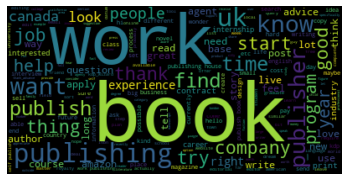

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(wordcloud_posts, interpolation='bilinear')
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

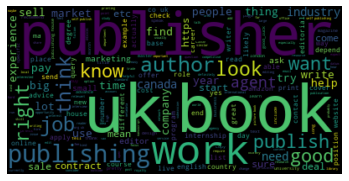

In [ ]:
plt.imshow(wordcloud_comments, interpolation='bilinear')
plt.axis("off")

In [ ]:
# incorporating time
# 
datetimes = pd.to_datetime(df['created'], unit='s')



```
Conclude the analysis:

How did this analysis address your research question?
Reflect on any new or unexpected patterns, consider further exploratory analysis into those patterns.
Identify any limitations of the analysis and how they may impact the results.
And then on to the next analysis/question.
```



It has already been found that a very small percentage of Reddit’s users create the vast majority of the site’s content, so we would not be surprised if only a few users could influence the discourse of entire subreddits. Identifying these users would help us understand how a subreddit's discourse is shaped. 

In [ ]:
df = df.sort_values(by='score', ascending=False)[:1000]
# Sanity check
print(df.shape)

In [ ]:
df.author.nunique()

In [ ]:
df.plot('score', 'num_comments', kind='scatter', color='black', alpha=0.25, logy=True)

In [ ]:
# bigger theme of social justice
# ideas for dictionary: the us, states of the US

In [ ]:
## Rank by geographic areas, map distribution
## Word embedding and topic modeling
## Cluster Analysis
## Sentiment analysis
## Network analysis

## Conclusion

```
This section is a brief summary of your analyses and final thoughts:

What was your conclusions in response to your research questions?
What are potential implications of these results to the broader community?
Reflect on how this project relates the the themes of the workshop.
How would you further develop this research project?
```

## References
*   Getting Started with Sentiment Analysis using Python. (n.d.). Retrieved July 17, 2022, from https://huggingface.co/blog/sentiment-analysis-python
*   King, G., Pan, J., & Roberts, M. E. (2013). How Censorship in China Allows Government Criticism but Silences Collective Expression. American Political Science Review, 107(2), 326–343. https://doi.org/10.1017/S0003055413000014
*   Lucy, L., Demszky, D., Bromley, P., & Jurafsky, D. (2020). Content Analysis of Textbooks via Natural Language Processing: Findings on Gender, Race, and Ethnicity in Texas U.S. History Textbooks. AERA Open, 6(3), 233285842094031. https://doi.org/10.1177/2332858420940312



**Tools:**
*   [Sentiment analysis](https://github.com/cjhutto/vaderSentiment)
*   [Getting started with sentiment analysis](https://huggingface.co/blog/sentiment-analysis-python)